<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/keep/Mini-bads3/Module3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format #comment

In [97]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [98]:
#https://drive.google.com/file/d/1tV3wDsawGcH-XjWXfWnHWGeNbf0Tp46q/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1tV3wDsawGcH-XjWXfWnHWGeNbf0Tp46q'})
fileDownloaded.GetContentFile('Supermarket.csv')

In [99]:
#df2 = pd.read_csv('Supermarket.csv')
#df2.head()

import time
chunksize = 10 ** 6
df2 = pd.DataFrame()
start = time.time()
for chunk in pd.read_csv('Supermarket.csv', iterator=True, chunksize = chunksize):
  df2 = pd.concat([df2,chunk])
end = time.time()
print("Loading time usage = ", end - start, " second. ")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading time usage =  17.284547567367554  second. 


In [100]:
print(df2.shape)
print(df2.head())
print(df2.describe())
print(df2.info())

(3158469, 22)
   SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  ...  STORE_CODE  STORE_FORMAT  STORE_REGION
0     200812   20080516             6  ...  STORE01026            SS           N01
1     200646   20070108             2  ...  STORE01300            LS           S03
2     200812   20080518             1  ...  STORE00343           XLS           W02
3     200632   20061005             5  ...  STORE01007           XLS           W01
4     200707   20070415             1  ...  STORE01794            LS           W01

[5 rows x 22 columns]
       SHOP_WEEK   SHOP_DATE  ...      SPEND          BASKET_ID
count 3158469.00  3158469.00  ... 3158469.00         3158469.00
mean   200701.95 20069683.63  ...       1.91 994105895023614.12
std        66.34     7210.26  ...       3.41      3374392489.99
min    200607.00 20060410.00  ...       0.00 994100100000097.00
25%    200636.00 20061031.00  ...       0.77 994103000208431.00
50%    200713.00 20070524.00  ...       1.23 994105900384506.00
75%    200742.00 

In [101]:
#!pip install pandasql

In [102]:
sql ='''
SELECT CUST_CODE, 
COUNT(DISTINCT BASKET_ID)/COUNT(DISTINCT SHOP_WEEK) AS VISIT_PER_WEEK,
COUNT(DISTINCT SHOP_WEEK) AS TOTAL_WEEK,
COUNT(DISTINCT PROD_CODE) AS TOTAL_PRODUCT,
SUM(SPEND) AS TOTAL_SALES
FROM df2
WHERE CUST_CODE IS NOT NULL GROUP BY CUST_CODE
HAVING TOTAL_SALES < 4000
'''
#from pandasql import sqldf
#df = sqldf(sql)
#print(df.head())

In [103]:
df = pd.DataFrame()
df['VISIT_PER_WEEK'] = (df2.groupby('CUST_CODE').BASKET_ID.nunique()/df2.groupby('CUST_CODE').SHOP_WEEK.nunique()).astype(int)
df['TOTAL_WEEK'] = df2.groupby('CUST_CODE').SHOP_WEEK.nunique()
df['TOTAL_PRODUCT'] = df2.groupby('CUST_CODE').PROD_CODE.nunique()
df['TOTAL_SALES'] = df2.groupby('CUST_CODE').SPEND.sum()
df = df[df['TOTAL_SALES'] < 4000]

print(df)
#type(df)

                VISIT_PER_WEEK  TOTAL_WEEK  TOTAL_PRODUCT  TOTAL_SALES
CUST_CODE                                                             
CUST0000000013               1          12             79       160.32
CUST0000000055               1          15             41       433.65
CUST0000000679               1          12             36        85.63
CUST0000001052               1          28             42       260.92
CUST0000001058               1           2             18        71.50
...                        ...         ...            ...          ...
CUST0000997627               1         109            438      1769.14
CUST0000998609               1          13             18        53.86
CUST0000998851               1          16            100       394.92
CUST0000998907               1         105            527      3721.02
CUST0000999786               1          80            202       802.52

[4794 rows x 4 columns]


In [104]:
#df = df.reset_index()
#df.sort_values(by="TOTAL_SALES",ascending=False, inplace=True)
#df.head()

In [105]:
x = df.iloc[:,0:-1] #1:3
x.head(5)

,VISIT_PER_WEEK,TOTAL_WEEK,TOTAL_PRODUCT
CUST_CODE,,,
CUST0000000013,1,12,79
CUST0000000055,1,15,41
CUST0000000679,1,12,36
CUST0000001052,1,28,42
CUST0000001058,1,2,18


In [106]:
y = df.iloc[:,-1:] # 3
y.head(5)

,TOTAL_SALES
CUST_CODE,
CUST0000000013,160.32
CUST0000000055,433.65
CUST0000000679,85.63
CUST0000001052,260.92
CUST0000001058,71.50


In [107]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression().fit(x_train, y_train)
#reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)
y_pred1 = reg.predict(x_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred1))
print('r2_score: %.2f' % r2_score(y_test, y_pred1))

[[74.11333332  6.30317026  4.49697602]]
[-216.34298197]
Mean squared error: 128573.10
r2_score: 0.85


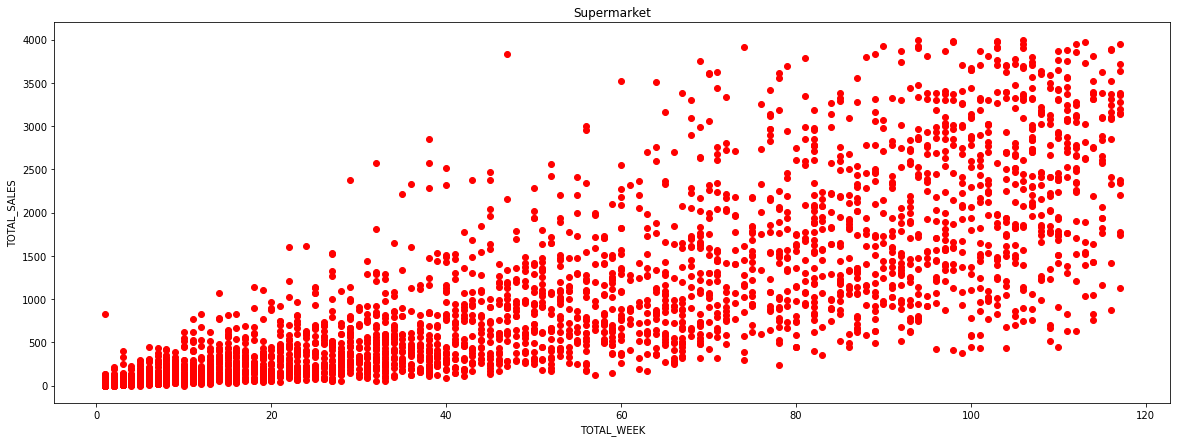

In [126]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,7))
i = 1
plt.scatter(x_train.iloc[:,i], y_train, color = 'red')
#plt.plot(x_train.iloc[:,1:2], np.reshape(train_result.predict([1, 2, 5, 50]),(-1,1)), color = 'blue')
plt.title('Supermarket')

plt.xlabel(x_train.columns[i])
plt.ylabel('TOTAL_SALES')
plt.show()

In [124]:
#Access row by index
x_train.iloc[0:1].VISIT_PER_WEEK[0]

1

# Exercise
### 1. Predict house price from this dataset https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/master/Week04-workshop-1/data.txt

1.1 Use linear regression to build a model for prediction <br>
1.2 Plot graph
